# Analysis of Attention U-Net (Experiment 02)

### Summary
This notebook analyzes the performance of the Attention U-Net model from `09_attention_unet.ipynb`. We compare its results directly to the baseline U-Net from Experiment 01 to isolate the impact of the attention mechanism.

### Initial Findings
- **Quantitative Performance**: The Attention U-Net achieved a best validation Dice score of **0.3920**, which is **lower** than the baseline's 0.4264.
- **Instability & Overfitting**: The model's performance is highly unstable, and it begins to overfit very early (peaking at epoch 2).

**Hypothesis**: The Attention U-Net is a more complex model. Without specialized preprocessing or a loss function tailored to the task, its increased capacity makes it more prone to overfitting on our dataset, leading to unstable and slightly worse results than the simpler baseline.

### Qualitative Performance (Visual Analysis)
The sample predictions confirm the low Dice score and support our hypothesis.
- **Failure Mode**: The model consistently identifies multiple high-intensity regions as potential ovaries, resulting in a high number of false positives.
- **Insight**: The attention mechanism alone is insufficient. The raw image data does not provide a clear enough signal for the model to distinguish the true ovary from other visually similar tissues (e.g., cysts, fluid, parts of the bowel). This strongly motivates the need for a preprocessing step that enhances the contrast of the target organ.

### Conclusion & Next Steps
This experiment demonstrates that a more complex architecture does not guarantee better performance, especially when the underlying data is challenging. The model's failure to focus correctly points directly to the next logical step in replicating the "RAovSeg" paper: implementing their **custom preprocessing function**. This function is specifically designed to make the ovaries "pop" in the image, which should provide a much stronger signal for the Attention U-Net to lock onto.

Successfully loaded model from ../models/09_attention_unet_best.pth
Loading manifest from ../data/d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the uterus.
Loaded 64 validation slices.

Visualizing 5 sample predictions...


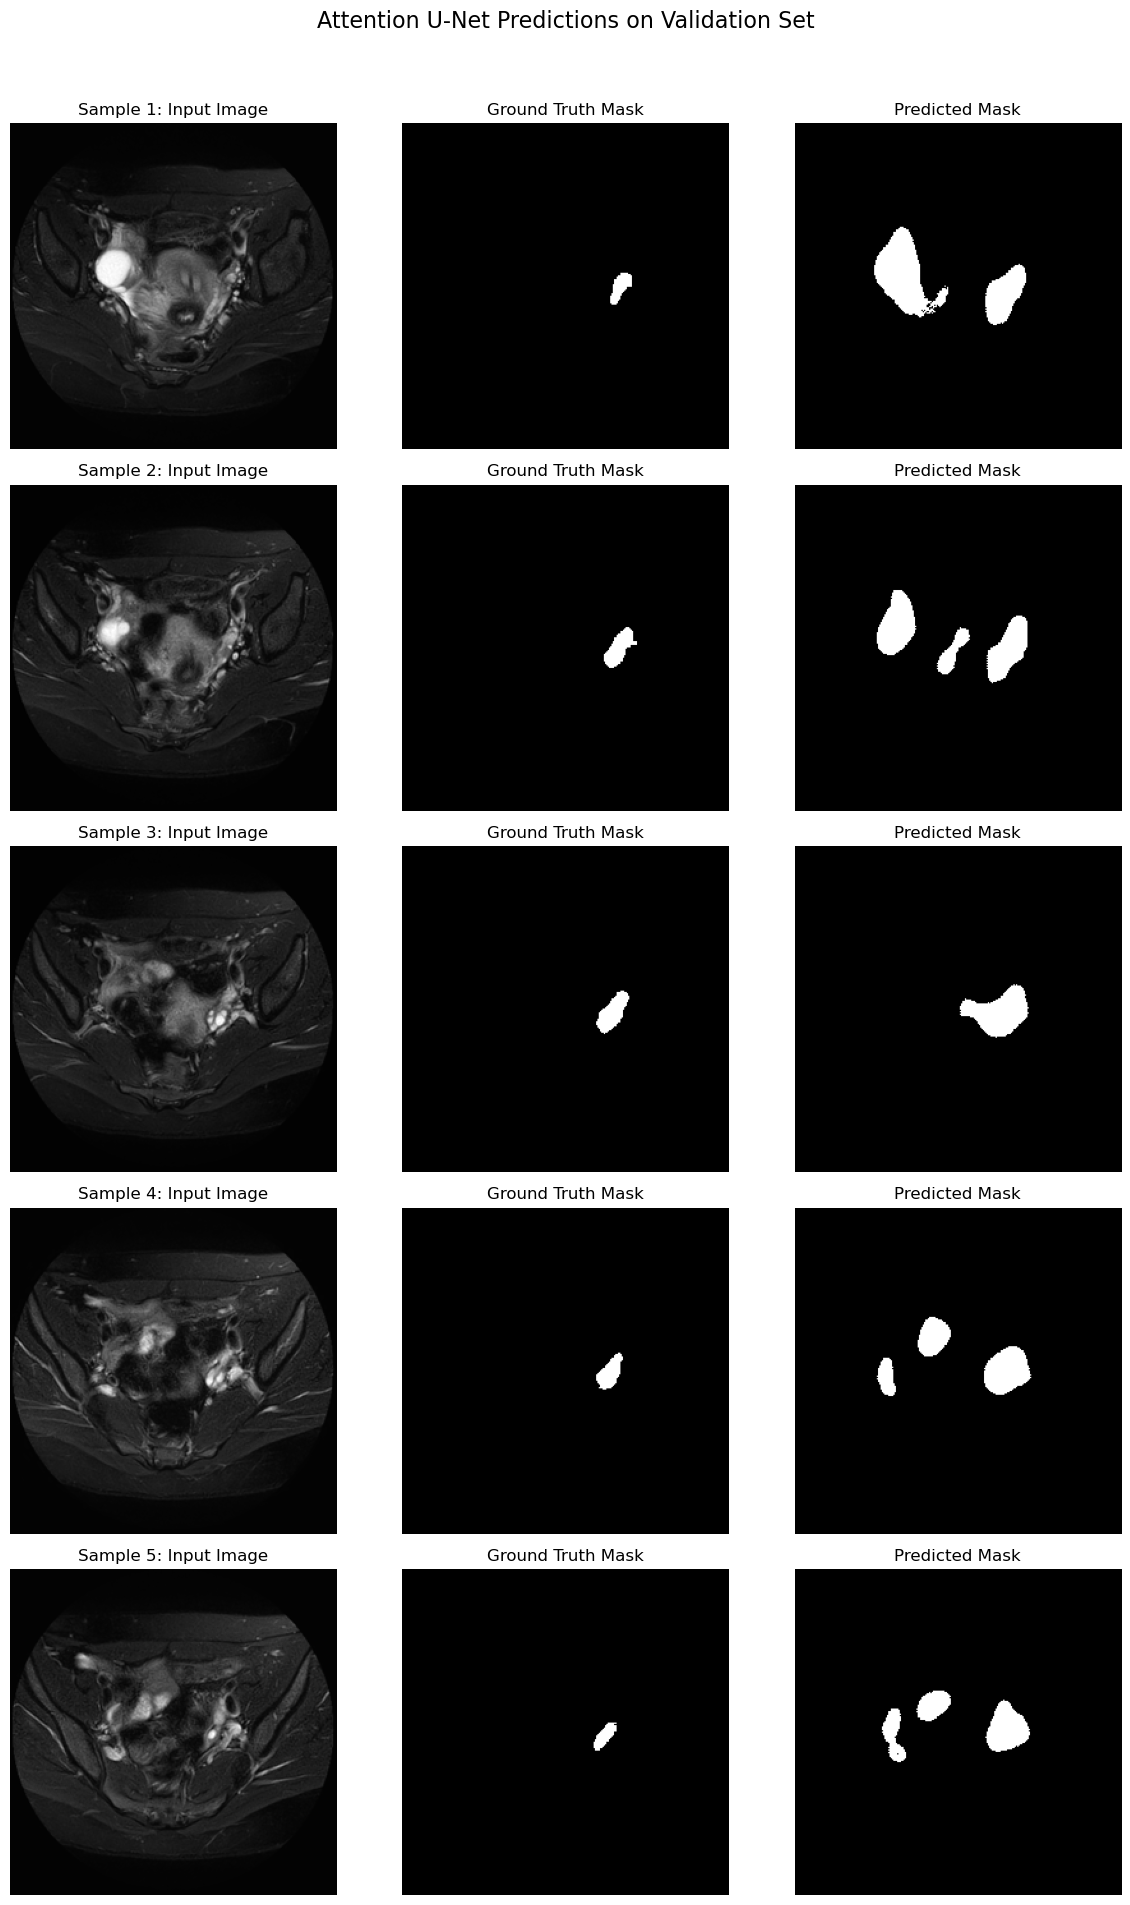

In [1]:
# --- Imports and Setup ---
import os
import torch
import matplotlib.pyplot as plt
import sys
import numpy as np
from torch.utils.data import DataLoader, Subset

# Add project root to path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import UterusDataset
from src.models import AttentionUNet # <--- CHANGE: We are now loading the AttentionUNet

# --- Configuration ---
# <--- CHANGE: Path to the new best model ---
model_path = "../models/09_attention_unet_best.pth" 
manifest_path = '../data/d2_manifest_t2fs_ovary_eligible.csv'
image_size = 256
num_samples_to_show = 5

# --- Load Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUNet(n_channels=1, n_classes=1).to(device) # <--- CHANGE: Instantiate AttentionUNet

try:
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Successfully loaded model from {model_path}")
except FileNotFoundError:
    print(f"FATAL ERROR: Model file not found at {model_path}. Please run the training in notebook 09.")
    exit()

# --- Load Validation Data (Identical to before) ---
val_full_dataset = UterusDataset(manifest_path=manifest_path, image_size=image_size, augment=False)
patient_ids = val_full_dataset.manifest['patient_id'].unique()
split_idx = int(len(patient_ids) * 0.8)
val_ids = patient_ids[split_idx:]
val_indices = [i for i, sm in enumerate(val_full_dataset.slice_map) if val_full_dataset.manifest.loc[sm['patient_index'], 'patient_id'] in val_ids]
val_dataset = Subset(val_full_dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

print(f"Loaded {len(val_dataset)} validation slices.")

# --- Perform and Visualize Inference ---
print(f"\nVisualizing {num_samples_to_show} sample predictions...")

fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(12, num_samples_to_show * 4))
fig.suptitle("Attention U-Net Predictions on Validation Set", fontsize=16)

with torch.no_grad():
    for i, (image, mask) in enumerate(val_loader):
        if i >= num_samples_to_show:
            break
        image = image.to(device)
        output = model(image)
        pred_mask = torch.sigmoid(output) > 0.5
        
        image_np = image.cpu().squeeze().numpy()
        mask_np = mask.cpu().squeeze().numpy()
        pred_mask_np = pred_mask.cpu().squeeze().numpy()
        
        axes[i, 0].imshow(image_np, cmap='gray')
        axes[i, 0].set_title(f"Sample {i+1}: Input Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_np, cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask_np, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()